Analyzing GloVe word embeddings dataset using high-dim tools.

In [1]:
import gensim.downloader as api

kv = api.load('glove-wiki-gigaword-300') # ~400k words × 300D

Creating sub-groups.

In [2]:
import json

# Load groups
with open("word_groups.json", "r", encoding="utf-8") as f:
    groups = json.load(f)

# remove duplicates + preserve order
def dedup(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

# intersect with kv and dedup
def present_in_kv(words, kv):
    return [w for w in dedup(words) if w in kv.key_to_index]

rank = {w: i for i, w in enumerate(kv.index_to_key)}
for k in groups:
    groups[k] = present_in_kv(groups[k], kv)
    groups[k] = sorted(groups[k], key=lambda w: rank.get(w, 10**9))

# Show summary
for name, lst in groups.items():
    print(f"{name:12}: {len(lst):4d} | sample: {lst[:10]}")

animals     :  169 | sample: ['turkey', 'fox', 'cricket', 'horse', 'dog', 'ray', 'bear', 'tiger', 'chicken', 'buffalo']
tools       :  114 | sample: ['level', 'saw', 'square', 'plane', 'bit', 'jack', 'die', 'file', 'camera', 'monitor']
professions :  114 | sample: ['director', 'secretary', 'coach', 'manager', 'judge', 'attorney', 'professor', 'lawyer', 'guard', 'model']
body_parts  :  134 | sample: ['back', 'head', 'face', 'hand', 'heart', 'blood', 'eye', 'foot', 'leg', 'temple']
fruits      :  128 | sample: ['date', 'rice', 'orange', 'apple', 'corn', 'wheat', 'pepper', 'olive', 'garlic', 'cherry']


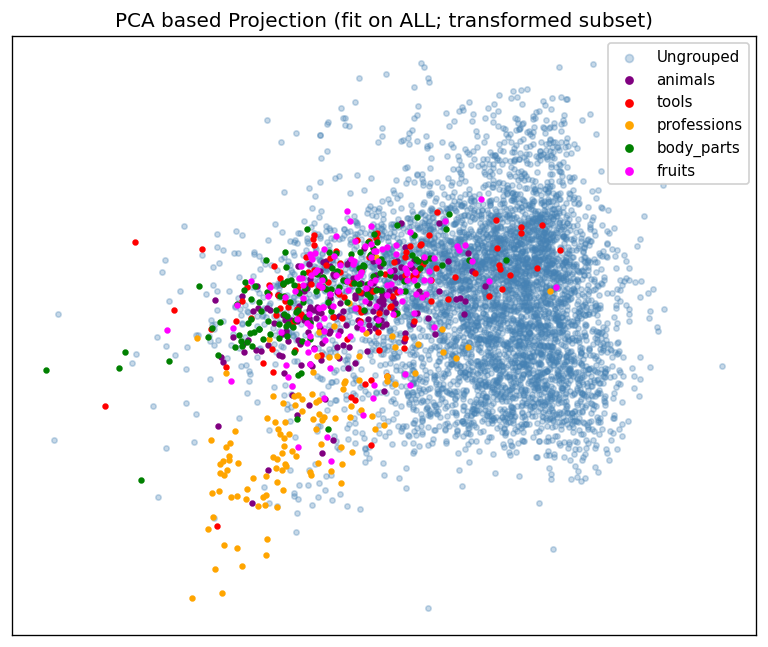

c:\Users\royha\miniconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


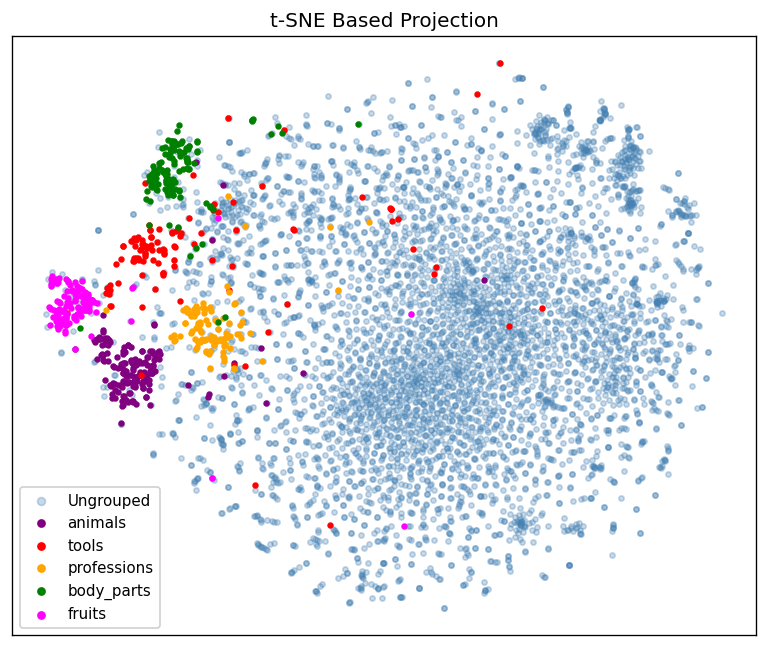

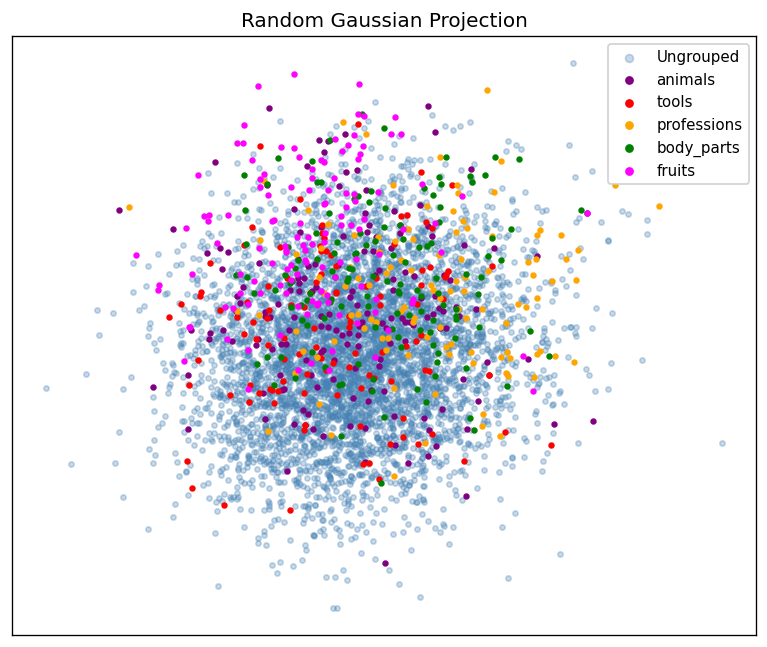

In [12]:
# --- 2D projections (PCA trained on ALL 400k, then transform subset) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection

# ==== CONFIG ====
N_UNASSIGNED = 5000   # random "Ungrouped" words to plot
MAX_PER_GROUP = None
SEED = 43

manual_palette = {
    "animals":     "purple",
    "tools":       "red",
    "professions": "orange",
    "body_parts":  "green",
    "fruits":      "magenta",
    "countries":   "teal",
    "numbers":     "brown",
    "Ungrouped":   "steelblue"
}

def collect_group_vecs_with_unassigned(kv, groups, n_unassigned=0, max_per_group=None, normalize=True, seed=0):
    rng = np.random.default_rng(seed)
    X, y, names, used_words = [], [], [], set()

    for gi, (name, words) in enumerate(groups.items()):
        ws = [w for w in words if w in kv.key_to_index]
        if max_per_group and len(ws) > max_per_group:
            ws = list(rng.choice(ws, size=max_per_group, replace=False))
        if not ws: 
            continue
        V = np.vstack([kv[w] for w in ws]).astype(np.float32)
        X.append(V); y.extend([gi]*len(ws)); names.append(name)
        used_words.update(ws)

    if n_unassigned > 0:
        all_vocab = [w for w in kv.index_to_key if w not in used_words]
        k = min(n_unassigned, len(all_vocab))
        extra = rng.choice(all_vocab, size=k, replace=False)
        Vx = np.vstack([kv[w] for w in extra]).astype(np.float32)
        X.append(Vx); y.extend([len(names)]*k); names.append("Ungrouped")

    X = np.vstack(X); y = np.array(y)
    if normalize:
        n = np.linalg.norm(X, axis=1, keepdims=True); n[n==0] = 1.0
        X = X / n
    return X, y, names

def plot_2d(Z, y, names, title):
    plt.figure(figsize=(6.5,5.5), dpi=120)
    if "Ungrouped" in names:
        gi_un = names.index("Ungrouped")
        idx_un = (y == gi_un)
        if np.any(idx_un):
            plt.scatter(Z[idx_un,0], Z[idx_un,1], s=10, alpha=0.30,
                        color=manual_palette.get("Ungrouped","steelblue"), label="Ungrouped")
    for gi, name in enumerate(names):
        if name == "Ungrouped": 
            continue
        idx = (y == gi)
        if np.any(idx):
            plt.scatter(Z[idx,0], Z[idx,1], s=8, color=manual_palette.get(name,"black"), label=name)
    plt.title(title); plt.xticks([]); plt.yticks([]); plt.legend(markerscale=1.5, fontsize=9, framealpha=0.9)
    plt.tight_layout(); plt.show()

# ===== Build the subset to plot =====
X_sub, y, names = collect_group_vecs_with_unassigned(
    kv, groups, n_unassigned=N_UNASSIGNED, max_per_group=MAX_PER_GROUP, normalize=True, seed=SEED
)

# ===== PCA: fit on ALL vectors, transform only the subset =====
# Normalize the FULL matrix as well (cosine geometry)
X_all = kv.vectors.astype(np.float32)
X_all /= (np.linalg.norm(X_all, axis=1, keepdims=True) + 1e-12)

pca_global = PCA(n_components=2, svd_solver="randomized", random_state=SEED)
_ = pca_global.fit(X_all)               # fit on ~400k x 300
Z_pca = pca_global.transform(X_sub)     # transform only the plotted subset
plot_2d(Z_pca, y, names, "PCA based Projection (fit on ALL; transformed subset)")

# ===== t-SNE (fit on subset only, as usual) =====
perp = max(5, min(35, X_sub.shape[0] // 100 * 5))
tsne = TSNE(n_components=2, perplexity=perp, learning_rate="auto", init="pca", n_iter=1000, random_state=SEED)
Z_tsne = tsne.fit_transform(X_sub)
plot_2d(Z_tsne, y, names, f"t-SNE Based Projection")

# ===== Random Projection (subset) =====
Z_rp = GaussianRandomProjection(n_components=2, random_state=SEED).fit_transform(X_sub)
plot_2d(Z_rp, y, names, "Random Gaussian Projection")